In [6]:
# Install required packages.
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
os.environ['TORCH'] = torch.__version__
print(f"torch version : {torch.__version__}")

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.

%matplotlib widget
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
import networkx as nx

import utils
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

1.12.1


'cuda'

Button(description='Run anim', style=ButtonStyle())

Button(description='Stop anim', style=ButtonStyle())

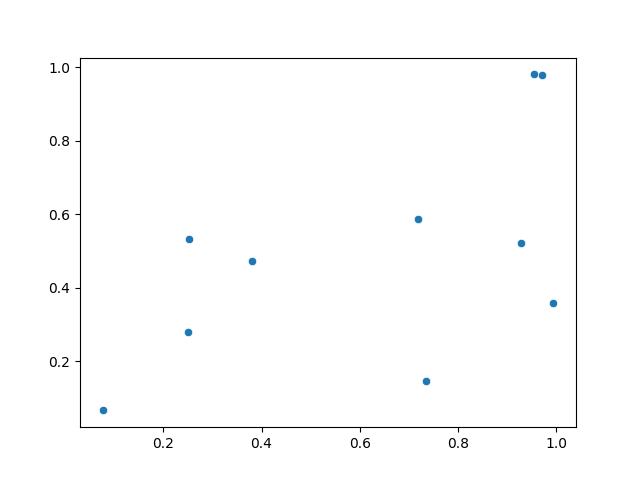

In [23]:
a = EmbeddingsScatterAnimation(np.random.uniform(size=(100,10, 2)), xlim=(0, 1), ylim=(0, 1))